In [1]:
!pip install ultralytics --upgrade
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!unzip /content/drive/MyDrive/Movies/Military.zip -d /content/drive/MyDrive/dataset/

Archive:  /content/drive/MyDrive/Movies/Military.zip
replace /content/drive/MyDrive/dataset/military_object_dataset/dataset.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [11]:
yaml_text = """
path: /content/drive/MyDrive/dataset/military_object_dataset
train: /content/drive/MyDrive/dataset/military_object_dataset/train
val: /content/drive/MyDrive/dataset/military_object_dataset/val
test: /content/drive/MyDrive/dataset/military_object_dataset/test

names:
  0: camouflage_soldier
  1: weapon
  2: military_tank
  3: military_truck
  4: military_vehicle
  5: civilian
  6: soldier
  7: civilian_vehicle
  8: military_artillery
  9: trench
  10: military_aircraft
  11: military_warship
"""
with open("military_dataset.yaml", "w") as f:
    f.write(yaml_text)

In [16]:
import os
import shutil

original_dataset = "/content/drive/MyDrive/dataset/military_object_dataset"
output_dataset = "/content/drive/MyDrive"

# Original to new class ID mapping
class_map = {1: 0, 3: 1, 4: 2, 8: 3, 11: 4}

# Define max number of images per split
split_limits = {
    'train': 200,
     'val': 100,
    'test': 100,
}

def process_split(split):
    img_in = f"{original_dataset}/{split}/images"
    lbl_in = f"{original_dataset}/{split}/labels"
    img_out = f"{output_dataset}/{split}/images"
    lbl_out = f"{output_dataset}/{split}/labels"

    os.makedirs(img_out, exist_ok=True)
    os.makedirs(lbl_out, exist_ok=True)

    image_count = 0
    limit = split_limits[split]

    for file in os.listdir(lbl_in):
        if image_count >= limit:
            break

        label_path = os.path.join(lbl_in, file)
        new_lines = []

        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                cls = int(parts[0])
                if cls in class_map:
                    new_lines.append(f"{class_map[cls]} {' '.join(parts[1:])}\n")

        if new_lines:
            # Write new label file
            with open(os.path.join(lbl_out, file), "w") as f:
                f.writelines(new_lines)

            # Copy corresponding image
            img_file = file.replace(".txt", ".jpg")
            src_img = os.path.join(img_in, img_file)
            dst_img = os.path.join(img_out, img_file)
            if os.path.exists(src_img):
                shutil.copy(src_img, dst_img)
                image_count += 1  # Count only if image is successfully copied

# Run on all splits
for split in ['train', 'val', 'test']:
    process_split(split)


In [17]:
import os
import shutil
from collections import defaultdict

# Paths
original_dataset = "/content/drive/MyDrive/dataset/military_object_dataset"
output_dataset = "/content/drive/MyDrive"

# Your selected class remap (original_id: new_id)
class_map = {
    1: 0,   # military_tank
    3: 1,   # military_aircraft
    4: 2,   # military_truck
    8: 3,   # military_artillery
    11: 4   # military_warship
}

# Class names in new ID order
class_names = {
    0: "military_tank",
    1: "military_aircraft",
    2: "military_truck",
    3: "military_artillery",
    4: "military_warship"
}

# Split limits
split_limits = {
    'train': 200,
    'val': 100,
    'test': 100
}

# Step 1: Count class distribution
def count_class_ids():
    class_counts = defaultdict(int)
    for split in ['train', 'val', 'test']:
        lbl_dir = os.path.join(original_dataset, split, 'labels')
        for file in os.listdir(lbl_dir):
            with open(os.path.join(lbl_dir, file), 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if parts:
                        cls = int(parts[0])
                        class_counts[cls] += 1
    return class_counts

# Step 2: Process and filter dataset
def process_split(split):
    img_in = os.path.join(original_dataset, split, "images")
    lbl_in = os.path.join(original_dataset, split, "labels")
    img_out = os.path.join(output_dataset, split, "images")
    lbl_out = os.path.join(output_dataset, split, "labels")

    os.makedirs(img_out, exist_ok=True)
    os.makedirs(lbl_out, exist_ok=True)

    image_count = 0
    limit = split_limits[split]

    for file in os.listdir(lbl_in):
        if image_count >= limit:
            break

        label_path = os.path.join(lbl_in, file)
        new_lines = []

        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                cls = int(parts[0])
                if cls in class_map:
                    new_cls = class_map[cls]
                    new_lines.append(f"{new_cls} {' '.join(parts[1:])}\n")

        if new_lines:
            with open(os.path.join(lbl_out, file), "w") as f:
                f.writelines(new_lines)

            img_file = file.replace(".txt", ".jpg")
            src_img = os.path.join(img_in, img_file)
            dst_img = os.path.join(img_out, img_file)

            if os.path.exists(src_img):
                shutil.copy(src_img, dst_img)
                image_count += 1

# Step 3: Write classes.txt
def write_classes_txt():
    with open(os.path.join(output_dataset, "classes.txt"), "w") as f:
        for i in range(len(class_names)):
            f.write(f"{class_names[i]}\n")

# Step 4: Write military_dataset.yaml
def write_yaml():
    yaml_path = os.path.join(output_dataset, "military_dataset.yaml")
    with open(yaml_path, "w") as f:
        f.write(f"path: {output_dataset}\n")
        f.write(f"train: {output_dataset}/train\n")
        f.write(f"val: {output_dataset}/val\n")
        f.write(f"test: {output_dataset}/test\n\n")
        f.write("names:\n")
        for i in range(len(class_names)):
            f.write(f"  {i}: {class_names[i]}\n")

# === Run the steps ===
print("🔍 Scanning dataset for class distribution...\n")
counts = count_class_ids()

print("📊 Class counts found in dataset:")
for cls_id, count in sorted(counts.items()):
    print(f"  Class ID {cls_id}: {count} annotations")

print("\n⚙️ Processing dataset with filtered/remapped classes...")
for split in ['train', 'val', 'test']:
    process_split(split)

write_classes_txt()
write_yaml()

print("\n✅ Done! Dataset cleaned, classes.txt and military_dataset.yaml written.")


🔍 Scanning dataset for class distribution...

📊 Class counts found in dataset:
  Class ID 0: 5376 annotations
  Class ID 1: 1568 annotations
  Class ID 2: 20059 annotations
  Class ID 3: 1489 annotations
  Class ID 4: 2464 annotations
  Class ID 5: 53 annotations
  Class ID 6: 7807 annotations
  Class ID 7: 586 annotations
  Class ID 8: 606 annotations
  Class ID 9: 44 annotations
  Class ID 10: 8636 annotations
  Class ID 11: 2134 annotations

⚙️ Processing dataset with filtered/remapped classes...

✅ Done! Dataset cleaned, classes.txt and military_dataset.yaml written.


In [18]:
yaml_text = """
path: /content/drive/MyDrive/reduced_dataset
train: train/images
val: val/images
test: test/images

names:
  0: weapon
  1: military_truck
  2: military_vehicle
  3: military_artillery
  4: military_warship
"""
with open("/content/drive/MyDrive/reduced_dataset.yaml", "w") as f:
    f.write(yaml_text)

In [19]:

import os
import shutil
import random

original_dataset = "/content/drive/MyDrive/dataset/military_object_dataset"
output_dataset = "/content/drive/MyDrive/reduced_dataset"

# Class ID mapping: original -> new
class_map = {1: 0, 3: 1, 4: 2, 8: 3, 11: 4}

# Max number of images per split
split_limits = {
    'train': 200,
    'val': 100,
    'test': 100
}

# For reproducibility
random.seed(42)

def process_split(split):
    img_in = os.path.join(original_dataset, split, "images")
    lbl_in = os.path.join(original_dataset, split, "labels")
    img_out = os.path.join(output_dataset, split, "images")
    lbl_out = os.path.join(output_dataset, split, "labels")

    os.makedirs(img_out, exist_ok=True)
    os.makedirs(lbl_out, exist_ok=True)

    valid_files = []

    # Step 1: Filter valid files that contain remappable classes
    for label_file in os.listdir(lbl_in):
        label_path = os.path.join(lbl_in, label_file)
        new_lines = []

        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                cls = int(parts[0])
                if cls in class_map:
                    new_lines.append(f"{class_map[cls]} {' '.join(parts[1:])}\n")

        # If the file has at least one valid class, keep it
        if new_lines:
            valid_files.append((label_file, new_lines))

    # Step 2: Shuffle and limit
    random.shuffle(valid_files)
    valid_files = valid_files[:split_limits[split]]

    # Step 3: Copy files to output
    for label_file, new_lines in valid_files:
        # Write filtered label file
        with open(os.path.join(lbl_out, label_file), "w") as f:
            f.writelines(new_lines)

        # Copy corresponding image
        img_file = label_file.replace(".txt", ".jpg")
        src_img_path = os.path.join(img_in, img_file)
        dst_img_path = os.path.join(img_out, img_file)

        if os.path.exists(src_img_path):
            shutil.copy(src_img_path, dst_img_path)

    print(f"{split.title()} set reduced to {len(valid_files)} filtered images.")

# Run for all splits
for split in ['train', 'val', 'test']:
    process_split(split)


Train set reduced to 200 filtered images.
Val set reduced to 100 filtered images.
Test set reduced to 100 filtered images.


In [20]:

# Count Images per set

import os

for split in ['train', 'val', 'test']:
    img_path = f"/content/drive/MyDrive/reduced_dataset/{split}/images"
    count = len(os.listdir(img_path))
    print(f"{split.title()} set: {count} images")

Train set: 392 images
Val set: 181 images
Test set: 144 images


In [31]:
# Class Frequency Distribution

from collections import Counter

labels_path = "/content/drive/MyDrive/reduced_dataset/train/labels"
class_counts = Counter()

for label_file in os.listdir(labels_path):
    with open(os.path.join(labels_path, label_file), 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            class_counts[class_id] += 1

# Map class IDs to names
class_names = [
     "weapon", "military_truck", "military_vehicle","military_artillery","military_warship"
]

for cid, count in sorted(class_counts.items()):
    print(f"{class_names[cid]}: {count}")


weapon: 113
military_truck: 111
military_vehicle: 210
military_artillery: 49
military_warship: 197


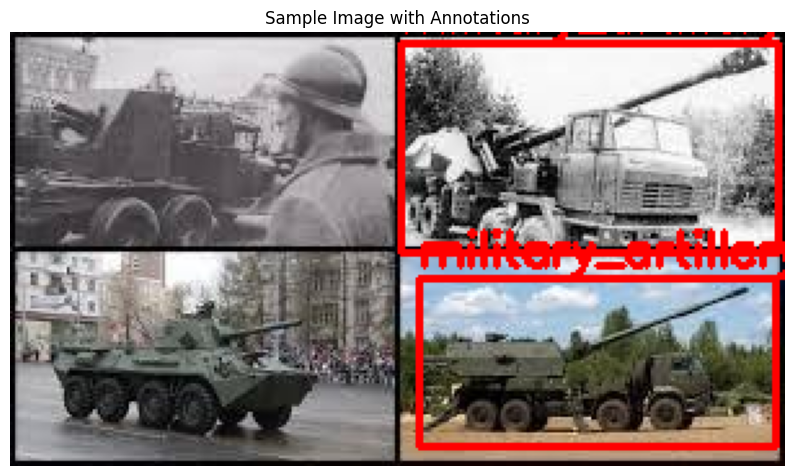

In [35]:
# Visualize Sample bounding boxes

import cv2
import matplotlib.pyplot as plt

img_dir = "/content/drive/MyDrive/reduced_dataset/train/images"
label_dir = "/content/drive/MyDrive/reduced_dataset/train/labels"

# Pick a sample image
img_file = os.listdir(img_dir)[4]
img_path = os.path.join(img_dir, img_file)
label_path = os.path.join(label_dir, img_file.replace(".jpg", ".txt"))

# Load image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

# Draw bounding boxes
with open(label_path, "r") as f:
    for line in f:
        cls, x, y, bw, bh = map(float, line.strip().split())
        x1 = int((x - bw/2) * w)
        y1 = int((y - bh/2) * h)
        x2 = int((x + bw/2) * w)
        y2 = int((y + bh/2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img, class_names[int(cls)], (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

plt.figure(figsize=(10, 9))
plt.imshow(img)
plt.axis('off')
plt.title("Sample Image with Annotations")
plt.show()

In [36]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
model.train(
    data="/content/drive/MyDrive/reduced_dataset.yaml",
    epochs=45,
    imgsz=640,
    batch=8,
    name="military_subset_yolo",
    patience=5,        # stops early if no improvement
    save_period=5      # saves weights every 5 epochs
)


Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/reduced_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=45, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=military_subset_yolo, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspect

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bf47c221790>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [37]:
yaml_text = """
path: /content/drive/MyDrive/reduced_dataset
train: /content/drive/MyDrive/reduced_dataset/train/images
val: /content/drive/MyDrive/reduced_dataset/val/images
nc: 5  # number of classes
names: ['weapon', 'military_truck', 'military_vehicle', 'military_artillery', 'military_warship']  # update with your actual class names
"""
with open("/content/drive/MyDrive/reduced_dataset.yaml", "w") as f:
    f.write(yaml_text)

from ultralytics import YOLO

# Load your best saved model (update path if needed)
model = YOLO("/content/runs/detect/military_subset_yolo/weights/best.pt")

In [38]:
metrics = model.val(data="/content/drive/MyDrive/reduced_dataset.yaml")
print(metrics.box.map50)  # or metrics.box.map

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 112.6±96.7 MB/s, size: 490.4 KB)
val: Scanning /content/drive/MyDrive/reduced_dataset/val/labels.cache... 181 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 181/181 194.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 2.8it/s 4.3s
                   all        181        326      0.533      0.513      0.498      0.283
                weapon         82        136      0.623      0.529      0.524      0.271
        military_truck         26         45      0.427      0.422      0.403      0.224
      military_vehicle         55        120      0.568      0.592      0.566      0.377
    military_artillery         20         25      0.514      0.507        0.5       0.26
Speed: 2.4ms preprocess, 5.2m

In [39]:
model = YOLO("/content/runs/detect/military_subset_yolo/weights/best.pt")
results = model.predict("/content/drive/MyDrive/reduced_dataset/test/images", save=True)


image 1/144 /content/drive/MyDrive/reduced_dataset/test/images/006008.jpg: 480x640 2 military_vehicles, 44.0ms
image 2/144 /content/drive/MyDrive/reduced_dataset/test/images/006009.jpg: 384x640 (no detections), 83.1ms
image 3/144 /content/drive/MyDrive/reduced_dataset/test/images/006012.jpg: 448x640 3 military_vehicles, 64.8ms
image 4/144 /content/drive/MyDrive/reduced_dataset/test/images/006027.jpg: 256x640 1 military_vehicle, 53.5ms
image 5/144 /content/drive/MyDrive/reduced_dataset/test/images/006043.jpg: 384x640 4 military_vehicles, 8.7ms
image 6/144 /content/drive/MyDrive/reduced_dataset/test/images/006044.jpg: 384x640 3 military_vehicles, 9.1ms
image 7/144 /content/drive/MyDrive/reduced_dataset/test/images/006046.jpg: 384x640 8 military_vehicles, 12.4ms
image 8/144 /content/drive/MyDrive/reduced_dataset/test/images/006047.jpg: 448x640 2 military_vehicles, 11.5ms
image 9/144 /content/drive/MyDrive/reduced_dataset/test/images/006053.jpg: 384x640 3 military_vehicles, 9.5ms
image 10

In [40]:
from ultralytics import YOLO

# Load the best model from training
model = YOLO("/content/runs/detect/military_subset_yolo/weights/best.pt")

# Run validation on the test set
metrics = model.val(model=model, data="/content/drive/MyDrive/reduced_dataset.yaml")

print("Test mAP@0.5:", metrics.box.map50)
print("Test mAP@0.5:0.95:", metrics.box.map)

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 55.4±48.3 MB/s, size: 139.6 KB)
val: Scanning /content/drive/MyDrive/reduced_dataset/val/labels.cache... 181 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 181/181 258.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 2.7it/s 4.5s
                   all        181        326      0.533      0.513      0.498      0.283
                weapon         82        136      0.623      0.529      0.524      0.271
        military_truck         26         45      0.427      0.422      0.403      0.224
      military_vehicle         55        120      0.568      0.592      0.566      0.377
    military_artillery         20         25      0.514      0.507        0.5       0.26
Speed: 2.8ms preprocess, 3.5ms

In [41]:
# Evaluate on validation dataset

metrics = model.val(data="/content/drive/MyDrive/reduced_dataset.yaml")

# Print key metrics
print("Precision:", metrics.box.p)
print("Recall:", metrics.box.r)
print("mAP@0.5:", metrics.box.map50)
print("mAP@0.5:0.95:", metrics.box.map)

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 139.3±232.5 MB/s, size: 841.5 KB)
val: Scanning /content/drive/MyDrive/reduced_dataset/val/labels.cache... 181 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 181/181 295.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 2.8it/s 4.3s
                   all        181        326      0.533      0.513      0.498      0.283
                weapon         82        136      0.623      0.529      0.524      0.271
        military_truck         26         45      0.427      0.422      0.403      0.224
      military_vehicle         55        120      0.568      0.592      0.566      0.377
    military_artillery         20         25      0.514      0.507        0.5       0.26
Speed: 2.5ms preprocess, 3.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /content/

In [42]:
metrics = model.val(data="/content/drive/MyDrive/reduced_dataset.yaml")

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 37.8±23.5 MB/s, size: 104.0 KB)
val: Scanning /content/drive/MyDrive/reduced_dataset/val/labels.cache... 181 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 181/181 233.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 2.8it/s 4.2s
                   all        181        326      0.533      0.513      0.498      0.283
                weapon         82        136      0.623      0.529      0.524      0.271
        military_truck         26         45      0.427      0.422      0.403      0.224
      military_vehicle         55        120      0.568      0.592      0.566      0.377
    military_artillery         20         25      0.514      0.507        0.5       0.26
Speed: 3.0ms preprocess, 3.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/ru

In [43]:
# Inference on test images
results = model.predict(
    source="/content/drive/MyDrive/reduced_dataset/test/images",
    save=True,
    conf=0.25  # Adjust confidence threshold
)



image 1/144 /content/drive/MyDrive/reduced_dataset/test/images/006008.jpg: 480x640 2 military_vehicles, 8.2ms
image 2/144 /content/drive/MyDrive/reduced_dataset/test/images/006009.jpg: 384x640 (no detections), 7.0ms
image 3/144 /content/drive/MyDrive/reduced_dataset/test/images/006012.jpg: 448x640 3 military_vehicles, 6.6ms
image 4/144 /content/drive/MyDrive/reduced_dataset/test/images/006027.jpg: 256x640 1 military_vehicle, 6.7ms
image 5/144 /content/drive/MyDrive/reduced_dataset/test/images/006043.jpg: 384x640 4 military_vehicles, 6.4ms
image 6/144 /content/drive/MyDrive/reduced_dataset/test/images/006044.jpg: 384x640 3 military_vehicles, 5.9ms
image 7/144 /content/drive/MyDrive/reduced_dataset/test/images/006046.jpg: 384x640 8 military_vehicles, 5.9ms
image 8/144 /content/drive/MyDrive/reduced_dataset/test/images/006047.jpg: 448x640 2 military_vehicles, 6.7ms
image 9/144 /content/drive/MyDrive/reduced_dataset/test/images/006053.jpg: 384x640 3 military_vehicles, 7.8ms
image 10/144 /

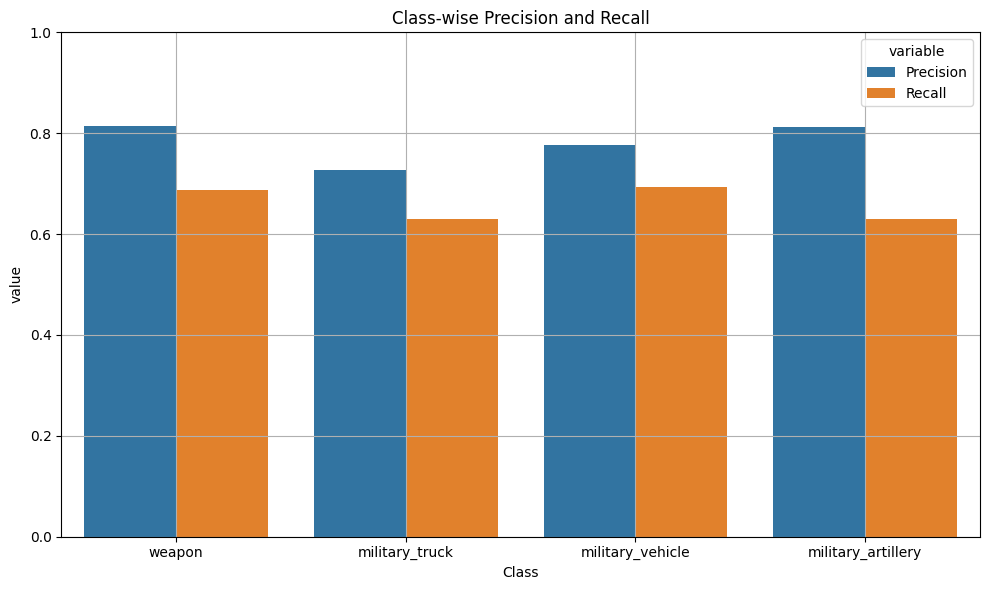

📌 Overall mAP@0.5: 0.737


In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Metrics from your output
classes = ["weapon", "military_truck", "military_vehicle", "military_artillery"]
precision = [0.81443, 0.72712, 0.77723, 0.81245]
recall = [0.68715, 0.63017, 0.69324, 0.62944]
map_50 = 0.73687

# Create DataFrame
df = pd.DataFrame({
    "Class": classes,
    "Precision": precision,
    "Recall": recall
})

# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df.melt(id_vars="Class"), x="Class", y="value", hue="variable")
plt.title("Class-wise Precision and Recall")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary
print("📌 Overall mAP@0.5:", round(map_50, 3))


# Optional: Save as CSV
df.to_csv("model_performance_report.csv", index=False)


In [45]:
# Load the trained model

from ultralytics import YOLO

# Load your best saved model (update path if needed)
model = YOLO("/content/runs/detect/military_subset_yolo/weights/best.pt")

In [46]:
# Predict on test images folder

# Run prediction on all test images
results = model.predict(
    source="/content/drive/MyDrive/reduced_dataset/test/images",  # path to test images
    conf=0.3,               # confidence threshold
    save=True,              # saves output images with boxes to a folder
    save_txt=True,          # optional: saves prediction txt files (YOLO format)
    project="runs/predict", # output base folder
    name="military_infer",  # subfolder name
    exist_ok=True           # overwrite if exists
)


image 1/144 /content/drive/MyDrive/reduced_dataset/test/images/006008.jpg: 480x640 2 military_vehicles, 6.5ms
image 2/144 /content/drive/MyDrive/reduced_dataset/test/images/006009.jpg: 384x640 (no detections), 8.2ms
image 3/144 /content/drive/MyDrive/reduced_dataset/test/images/006012.jpg: 448x640 3 military_vehicles, 6.7ms
image 4/144 /content/drive/MyDrive/reduced_dataset/test/images/006027.jpg: 256x640 1 military_vehicle, 6.7ms
image 5/144 /content/drive/MyDrive/reduced_dataset/test/images/006043.jpg: 384x640 4 military_vehicles, 6.9ms
image 6/144 /content/drive/MyDrive/reduced_dataset/test/images/006044.jpg: 384x640 3 military_vehicles, 6.0ms
image 7/144 /content/drive/MyDrive/reduced_dataset/test/images/006046.jpg: 384x640 8 military_vehicles, 6.4ms
image 8/144 /content/drive/MyDrive/reduced_dataset/test/images/006047.jpg: 448x640 2 military_vehicles, 6.6ms
image 9/144 /content/drive/MyDrive/reduced_dataset/test/images/006053.jpg: 384x640 3 military_vehicles, 6.8ms
image 10/144 /

In [49]:
# Display few output images

import matplotlib.pyplot as plt
import cv2
import os

# Change path based on output
output_path = "/content/runs/detect/predict"

# List predicted images
# Only list image files
predicted_images = [f for f in os.listdir(output_path) if f.endswith(('.jpg', '.jpeg', '.png',))]

# Display first  predictions
for i in range(min(50, len(predicted_images))):
    img = cv2.imread(os.path.join(output_path, predicted_images[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_images[i]}")
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# New Section

In [50]:

# save predictions to drive

!cp -r runs/predict/military_infer /content/runs/predict/military_infer/

cp: cannot copy a directory, 'runs/predict/military_infer', into itself, '/content/runs/predict/military_infer/military_infer'


In [56]:
!pip install streamlit streamlit_option_menu ultralytics

In [57]:
%%writefile military.py

import streamlit as st
from ultralytics import YOLO
from PIL import Image
import numpy as np

st.title("Military Object Detection using YOLOv8")
st.markdown("Upload an image to detect")

# Load model
model = YOLO("/content/runs/detect/military_subset_yolo/weights/best.pt")

uploaded_file = st.file_uploader("Upload Image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    img = Image.open(uploaded_file).convert("RGB")
    st.image(img, caption="Uploaded Image", use_column_width=True)

    with st.spinner("Detecting..."):
        results = model.predict(img, conf=0.3)
        result_img = results[0].plot()

        st.image(result_img, caption="Detection Result", use_column_width=True)

        # Optional: show detected classes
        st.subheader("Detected Classes")
        for box in results[0].boxes.data:
            cls = int(box[-1])
            conf = box[-2].item()
            st.write(f"Class ID: {cls}, Confidence: {conf:.2f}")


Overwriting military.py


In [58]:
!pip install -q streamlit
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
import subprocess
subprocess.Popen(["./cloudflared-linux-amd64", "tunnel", "--url", "http://localhost:8501"])
!nohup /content/cloudflared-linux-amd64 tunnel --url http://localhost:8501 &

--2026-01-07 07:30:00--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64 [following]
--2026-01-07 07:30:00--  https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/955e9d1b-ac5e-4188-8867-e5f53958a8fe?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-01-07T08%3A25%3A41Z&rscd=attachment%3B+filename%3Dcloudflared-linux-amd64&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2026-01-07

In [59]:
!streamlit run /content/military.py &>/content/logs.txt &

In [61]:
!grep -o 'https://.*\.trycloudflare.com' nohup.out | head -n 1 | xargs -I {} echo "Your tunnel url {}"

Your tunnel url https://pressing-cornell-resumes-diamonds.trycloudflare.com
